In [1]:
import os
import time

from io import StringIO

import pandas as pd

import requests
from requests.adapters import HTTPAdapter, Retry

In [2]:
DATA_DIR = "../data/"

### Load KOMODO

In [3]:
komodo_df = pd.read_csv(
    os.path.join(
        DATA_DIR,
        "komodo",
        "komodo.tsv"
    ),
    sep="\t"
)

# Transform taxon ID column to string for plotting
komodo_df["Taxon ID"] = komodo_df["Taxon ID"]\
    .astype(str)\
    .str.replace(".0", "")

# Add genus column
komodo_df["Genus"] = komodo_df["Organism Name"].str.split(" ").str[0]

komodo_df

,Organism DSMZ ID,Taxon ID,Organism Name,Media,Genus
0,6268,nan,NaN,Substrate for DSM 6268,NaN
1,9849,46125,Abiotrophia defectiva,PYG-MEDIUM (modified),Abiotrophia
2,14247,291968,Acaricomes phytoseiuli,TRYPTICASE SOY Yeast extract medium,Acaricomes
3,23669,nan,Acetatifactor muris,For DSM 23669,Acetatifactor
4,5522,2382,Acetitomaculum ruminis,ACETITOMACULUM medium | METHANOBACTERIUM medium,Acetitomaculum
...,...,...,...,...,...
8623,473,120045,Zymomonas mobilis subsp. mobilis,ZYMOMONAS medium,Zymomonas
8624,22645,120044,Zymomonas mobilis subsp. pomaceae,ZYMOMONAS medium,Zymomonas
8625,7201,86958,Zymophilus paucivorans,MEDIUM 58 MODIFIED FOR DSM 7201,Zymophilus
8626,20765,86959,Zymophilus raffinosivorans,MEDIUM 58 MODIFIED FOR DSM 20765,Zymophilus


In [4]:

# Drop missing media and Taxon IDs
komodo_df = komodo_df\
    .replace("nan", None)\
    .dropna(subset=["Taxon ID", "Media"])

komodo_df

,Organism DSMZ ID,Taxon ID,Organism Name,Media,Genus
1,9849,46125,Abiotrophia defectiva,PYG-MEDIUM (modified),Abiotrophia
2,14247,291968,Acaricomes phytoseiuli,TRYPTICASE SOY Yeast extract medium,Acaricomes
4,5522,2382,Acetitomaculum ruminis,ACETITOMACULUM medium | METHANOBACTERIUM medium,Acetitomaculum
5,1870,35830,Acetivibrio cellulolyticus,ACETIVIBRIO CELLULOLYTICUS MEDIUM,Acetivibrio
6,3005,290052,Acetivibrio ethanolgignens,PYG medium WITH VOLATILE FATTY ACIDS,Acetivibrio
...,...,...,...,...,...
8622,18599,325472,Zymomonas mobilis subsp. francensis,ZYMOMONAS medium,Zymomonas
8623,473,120045,Zymomonas mobilis subsp. mobilis,ZYMOMONAS medium,Zymomonas
8624,22645,120044,Zymomonas mobilis subsp. pomaceae,ZYMOMONAS medium,Zymomonas
8625,7201,86958,Zymophilus paucivorans,MEDIUM 58 MODIFIED FOR DSM 7201,Zymophilus


### Map organism name to KEGG ID (3 letter code)

The kegg-organisms.txt was obtained by downloading the data in https://rest.kegg.jp/list/genome

In [5]:
kegg_org = pd.read_table(
    os.path.join(
        DATA_DIR,
        "kegg",
        "kegg-organisms.txt"
    ),
    names=["KEGG Taxonomy", "KEGG ID", "Organism Name", "Classification"]
)

# kegg_org[["Domain", "Kingdom", "Phylum", "Class"]] = \
#     kegg_org["Classification"].str.split(";", expand=True)

kegg_org

,KEGG Taxonomy,KEGG ID,Organism Name,Classification
0,T01001,hsa,Homo sapiens (human),Eukaryotes;Animals;Vertebrates;Mammals
1,T01005,ptr,Pan troglodytes (chimpanzee),Eukaryotes;Animals;Vertebrates;Mammals
2,T02283,pps,Pan paniscus (bonobo),Eukaryotes;Animals;Vertebrates;Mammals
3,T02442,ggo,Gorilla gorilla gorilla (western lowland gorilla),Eukaryotes;Animals;Vertebrates;Mammals
4,T01416,pon,Pongo abelii (Sumatran orangutan),Eukaryotes;Animals;Vertebrates;Mammals
...,...,...,...,...
9932,T09593,lob,Candidatus Lokiarchaeum ossiferum,Prokaryotes;Archaea;Lokiarchaeota;Lokiarchaeum
9933,T06555,psyt,Candidatus Prometheoarchaeum syntrophicum,Prokaryotes;Archaea;Lokiarchaeota;Prometheoarc...
9934,T09928,oyw,Candidatus Odinarchaeum yellowstonii,Prokaryotes;Archaea;Odinarchaeota;Odinarchaeum
9935,T03835,agw,Archaeon GW2011_AR10,Prokaryotes;Archaea;unclassified Archaea


In [6]:
kegg_org_match = pd.merge(
    left=kegg_org,
    right=komodo_df,
    on="Organism Name",
    how="inner"
)

kegg_org_match

,KEGG Taxonomy,KEGG ID,Organism Name,Classification,Organism DSMZ ID,Taxon ID,Media,Genus
0,T00811,efe,Escherichia fergusonii,Prokaryotes;Bacteria;Enterobacterales;Escherichia,13698,564,NUTRIENT AGAR,Escherichia
1,T03986,eal,Escherichia albertii,Prokaryotes;Bacteria;Enterobacterales;Escherichia,17582,208962,TRYPTICASE SOY BROTH AGAR,Escherichia
2,T00627,ses,Salmonella enterica subsp. arizonae,Prokaryotes;Bacteria;Enterobacterales;Salmonella,9386,59203,NUTRIENT AGAR,Salmonella
3,T03709,eclz,Enterobacter hormaechei subsp. hormaechei,Prokaryotes;Bacteria;Enterobacterales;Enteroba...,12409,301105,CASO AGAR (Merck 105458),Enterobacter
4,T05545,ecan,Enterobacter cancerogenus,Prokaryotes;Bacteria;Enterobacterales;Enteroba...,17580,69218,TRYPTICASE SOY BROTH AGAR,Enterobacter
...,...,...,...,...,...,...,...,...
1737,T08588,vso,Vulcanisaeta souniana,Prokaryotes;Archaea;Thermoproteota;Vulcanisaeta,14430,164452,For DSM 14429 and DSM 14430,Vulcanisaeta
1738,T00446,tpe,Thermofilum pendens,Prokaryotes;Archaea;Thermoproteota;Thermofilum,2475,2269,THERMOFILUM PENDENS medium,Thermofilum
1739,T01283,asc,Acidilobus saccharovorans,Prokaryotes;Archaea;Thermoproteota;Acidilobus,16705,242703,For DSM 16705,Acidilobus
1740,T02380,clg,Caldisphaera lagunensis,Prokaryotes;Archaea;Thermoproteota;Caldisphaera,15908,200415,CALDISPHAERA medium,Caldisphaera


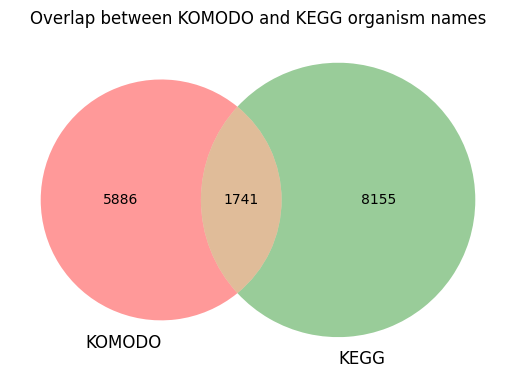

In [7]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

venn2(
    [
        set(komodo_df["Organism Name"]),
        set(kegg_org["Organism Name"])
    ],
    (
        "KOMODO",
        "KEGG"
    )
)
plt.title("Overlap between KOMODO and KEGG organism names")
plt.show()

### Retrieve EC numbers for the given organism names

In [8]:
# Initialize results CSV file
results_path = os.path.join(
    DATA_DIR,
    "kegg",
    "taxon2ec-kegg.csv"
)
record_columns = [
    "Gene",
    "EC",
    "KEGG ID"
]
pd.DataFrame(columns=record_columns).to_csv(
    results_path,
    index=False,
    mode="w"
)

retries = Retry(
    total=5,
    backoff_factor=0.25,
    status_forcelist=[500, 502, 503, 504]
)
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

id_list = kegg_org_match["KEGG ID"].unique()

for id_idx, kegg_id in enumerate(id_list):

    # print(f"[+] Retrieving EC numbers for organism: {kegg_id}")

    url = f"https://rest.kegg.jp/link/ec/{kegg_id}"

    response = session.get(url)
    response.raise_for_status()

    response_df = pd.read_table(
        StringIO(response.text),
        names=["Gene", "EC"]
    )

    # Remove leading "ec"
    response_df["EC"] = response_df["EC"].str.replace("ec:", "")

    # Add KEGG ID column
    response_df["KEGG ID"] = kegg_id

    # Save dataframe to file
    response_df.to_csv(
        results_path,
        index=False,
        header=False,
        mode="a"
    )

    # Delete dataframe to save space
    del response_df

    if id_idx % 10 == 0:
        print(
            f"[+] Processed organism {kegg_id} ({id_idx} / {len(id_list)})"
        )

    time.sleep(0.25)

[+] Processed organism efe (1 / 1742)
[+] Processed organism cro (11 / 1742)
[+] Processed organism lax (21 / 1742)
[+] Processed organism yin (31 / 1742)
[+] Processed organism sfj (41 / 1742)
[+] Processed organism brb (51 / 1742)
[+] Processed organism tpty (61 / 1742)
[+] Processed organism pala (71 / 1742)
[+] Processed organism opo (81 / 1742)
[+] Processed organism bsun (91 / 1742)
[+] Processed organism apag (101 / 1742)
[+] Processed organism xhy (111 / 1742)
[+] Processed organism lgu (121 / 1742)
[+] Processed organism vro (131 / 1742)
[+] Processed organism vnv (141 / 1742)
[+] Processed organism ppr (151 / 1742)
[+] Processed organism pamg (161 / 1742)
[+] Processed organism pkr (171 / 1742)
[+] Processed organism ppsl (181 / 1742)
[+] Processed organism acx (191 / 1742)
[+] Processed organism ajo (201 / 1742)
[+] Processed organism aber (211 / 1742)
[+] Processed organism mcun (221 / 1742)
[+] Processed organism sbk (231 / 1742)
[+] Processed organism part (241 / 1742)
[+